In [78]:
import pathlib

worker_image = 'us-east4-docker.pkg.dev/catx-x-taara/radlab-silicon-tuning-containers/silicon-design-ubuntu-2004'
staging_bucket = 'catx-x-taara-radlab-silicon-tuning-staging'
project = 'catx-x-taara'
location = 'us-east4'
machine_type = 'n1-standard-8'
notebook = 'mmi.ipynb'
prefix = pathlib.Path(notebook).stem
staging_dir = f'{prefix}-tuning_2'

max_trial_count = 1000

## Fetch notebooks for all study trials

In [ ]:
import pathlib
from google.cloud import storage
import tqdm

local_dir = pathlib.Path(staging_dir)
local_dir.mkdir(exist_ok=True, parents=True)

client = storage.Client()
bucket = client.bucket(staging_bucket)
for i in tqdm.tqdm(range(1, max_trial_count+1)):
    src = bucket.blob(f'{staging_dir}/{i}/model/{prefix}_out.ipynb')
    if not src.exists():
        break
    dst = local_dir / f'{prefix}_out_{i}.ipynb'
    with dst.open('wb') as f:
        src.download_to_file(f)

 26% 264/1000 [01:56<05:18,  2.31it/s]

## Extract metrics from notebooks

In [101]:
import scrapbook as sb
books = sb.read_notebooks(str(local_dir))

In [102]:
import pathlib
import math
import pandas as pd
import tqdm

def metrics():
    for b in tqdm.tqdm(books):
        trial_id = int(pathlib.Path(books[b].filename).stem.split('_')[-1])
        param_1 = float(books[b].parameters.width_mmi)
        param_2 = float(books[b].parameters.length_mmi)
        param_3 = float(books[b].parameters.gap_mmi)
        param_4 = float(books[b].parameters.width_taper)
        
        if 'metrics' in books[b].scraps:
            metrics = books[b].scraps['metrics'].data
            yield trial_id, param_1, param_2, param_3, param_4, books[b].scraps['transmission_1550'].data
        else:
            yield trial_id, param_1, param_2, param_3, param_4, math.nan
        
df = pd.DataFrame.from_records(metrics(), columns=['TRIAL_ID', 'width_mmi', 'length_mmi', 'gap_mmi', 'width_taper', 'transmission_1550'], index='TRIAL_ID').sort_index()

(df
    .sort_values(['transmission_1550'], ascending=[True])
    .style.bar(color='lightblue', vmin=0.001, subset=['transmission_1550'])
    .background_gradient(subset=['width_mmi'], cmap='Greens')
    .background_gradient(subset=['length_mmi'], cmap='Blues')
    .background_gradient(subset=['gap_mmi'], cmap='Oranges')
    .background_gradient(subset=['width_taper'], cmap='Purples')
)

100% 400/400 [00:04<00:00, 83.56it/s]


,width_mmi,length_mmi,gap_mmi,width_taper,transmission_1550
TRIAL_ID,,,,,
399,3.676641,16.984478,1.791284,1.000000,0.047977
103,3.000000,5.000000,2.000000,2.000000,0.050095
117,7.081062,5.000000,2.000000,2.000000,0.061975
112,9.268743,5.000000,2.000000,1.960100,0.063051
114,6.428047,17.000000,2.000000,1.000000,0.079462
338,4.934988,5.000000,2.000000,2.000000,0.079514
121,3.000000,17.000000,1.460712,2.000000,0.085958
108,3.000000,17.000000,2.000000,1.000000,0.097963
17,5.415421,5.000000,1.794323,1.575139,0.099974


## Plot experiments

array([[<AxesSubplot:xlabel='width_mmi', ylabel='width_mmi'>,
        <AxesSubplot:xlabel='length_mmi', ylabel='width_mmi'>,
        <AxesSubplot:xlabel='gap_mmi', ylabel='width_mmi'>,
        <AxesSubplot:xlabel='width_taper', ylabel='width_mmi'>],
       [<AxesSubplot:xlabel='width_mmi', ylabel='length_mmi'>,
        <AxesSubplot:xlabel='length_mmi', ylabel='length_mmi'>,
        <AxesSubplot:xlabel='gap_mmi', ylabel='length_mmi'>,
        <AxesSubplot:xlabel='width_taper', ylabel='length_mmi'>],
       [<AxesSubplot:xlabel='width_mmi', ylabel='gap_mmi'>,
        <AxesSubplot:xlabel='length_mmi', ylabel='gap_mmi'>,
        <AxesSubplot:xlabel='gap_mmi', ylabel='gap_mmi'>,
        <AxesSubplot:xlabel='width_taper', ylabel='gap_mmi'>],
       [<AxesSubplot:xlabel='width_mmi', ylabel='width_taper'>,
        <AxesSubplot:xlabel='length_mmi', ylabel='width_taper'>,
        <AxesSubplot:xlabel='gap_mmi', ylabel='width_taper'>,
        <AxesSubplot:xlabel='width_taper', ylabel='width_taper'

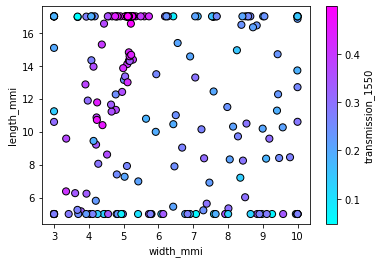

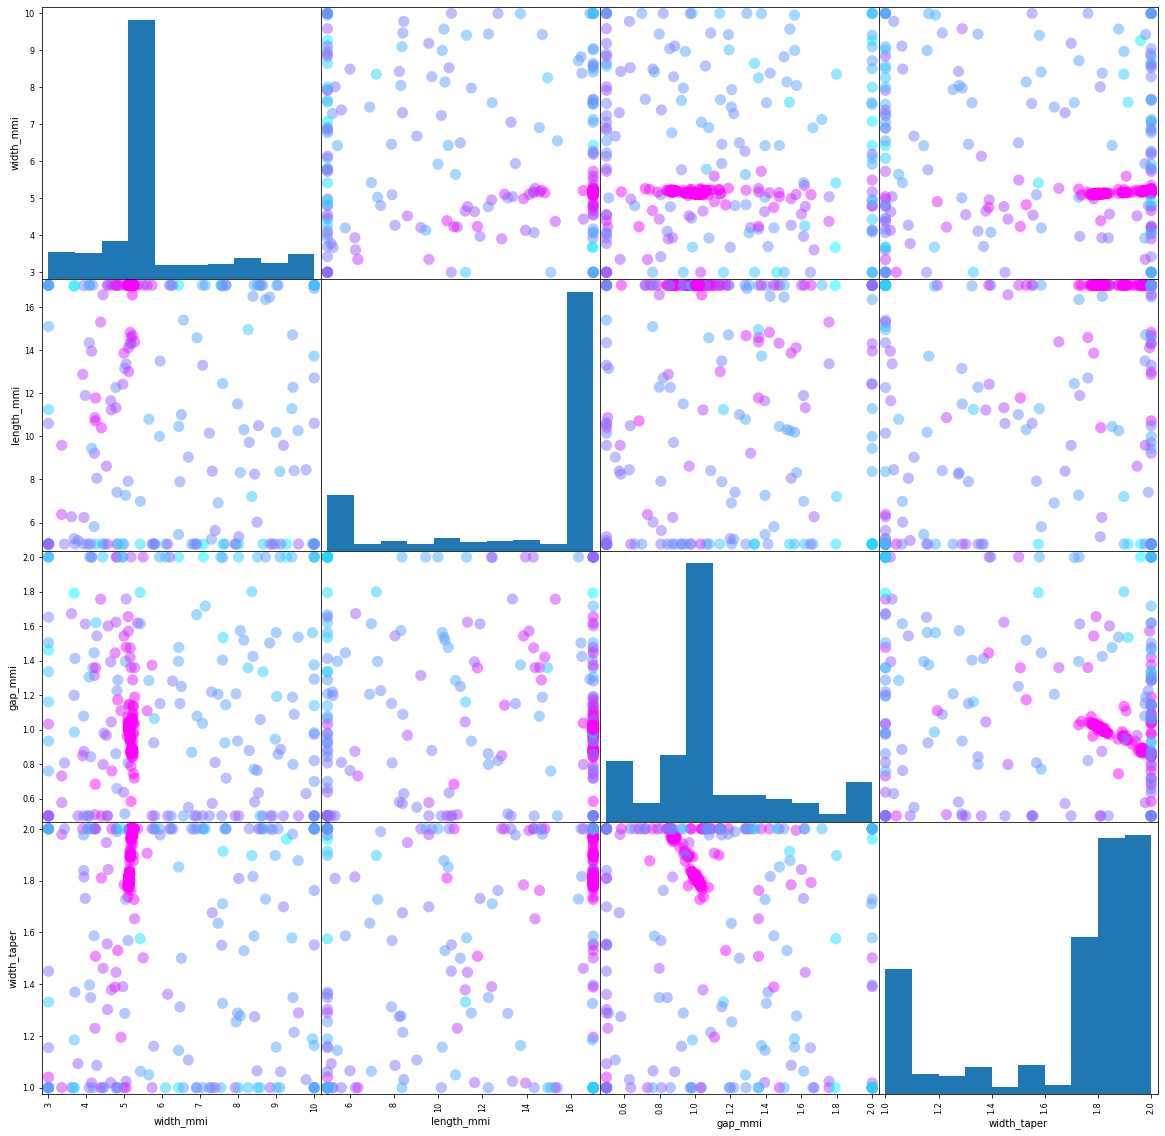

In [103]:
import matplotlib.colors
from matplotlib import pyplot as plt

cool =  matplotlib.colormaps['cool']
cool.set_bad(color='none')
ax = df.plot.scatter(x='width_mmi', y='length_mmi', c='transmission_1550',
                cmap=cool, s=50, sharex=False, plotnonfinite=True, alpha=1.0, edgecolor='black')
ax
pd.plotting.scatter_matrix(df.drop(columns='transmission_1550'), c=df['transmission_1550'].to_numpy(), cmap='cool', figsize=(20,20), s=500)